In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.scale as mscale
from scipy import stats
import datetime as dt
%matplotlib inline

In [2]:
bank_marketing = pd.read_csv('bank-full.csv', sep=';')
bank_marketing.index.name = 'client'

# Portuguese Banking Institution Database For Long-Term Deposit Product Marketing Campaign

## Release

This dataset lists bank clients of a Portuguese banking institution on whom they conducted a direct marketing campaign for a savings deposit product. It was originally released in 2011 by Moro et al., a machine learning research team, who revised it with commensurate macroeconomic data in 2014. The team collected the information directly from the enterprise's databases, though only 17 of the 29 attributes used by the ML algorithms are made available to the public. The information represents the results of a direct marketing campgain conducted by the bank and was collected via phone calls to clients dated from May 2008 to November 2010.

## Datasets and Attributes

There are 45211 clients in this dataset out of the original 79354, the result of these researchers removing missing values in the original 59 attributes so that their ML algorithms were working with cleaner data.

This entry in the UCI ML library hosts two datasets, each with a 10% sample used for the ML activity and a full version, which I used here. The 2nd dataset is a modification of the 1st, finalized in 2014 to include 5 attributes of macroeconomic data:
16.quarterly employment variation rate
17.monthly consumer price index
18.monthly consumer confidence index
19.daily euribor 3 month rate
20.quarterly total of employed Portuguese.

I worked with the original set because of the claim of no missing values. There are a total of 17 attributes collected for each client:
1.age
2.job: category
3.martital: status
4.education
5.default: possesses credit in default
6.housing: loan?
7.personal: loan?
8.contact: method used to engage client
9.month of last client engagement
10.day of last client engagement
11.duration of last client engagement
12.campaign: # of engagements during the period of the campaign
13.pdays: days passed between engagement during prior campaign and engagement this campaign
14.previous: number of engagements during last campaign for this client
15.poutcome: outcome of previous marketing campaign for this client

The header data can be seen below.

In [3]:
bank_marketing.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
client,,,,,,,,,,,,,,,,,
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# Analytic Questions

## 1) Who are the bank clients? How do their demographics vary by age, occupation, marital status, education, and housing?

We first will get a handle on this data by exploring the subjects of the marketing campaign. This data set gave some basic demography information in the context of financial services from this major European banking institution. Let's look at the ages involved.

In [4]:
print('The minimum age is {} and the maximum is {}'.format(min(bank_marketing.age), max(bank_marketing.age)))

The minimum age is 18 and the maximum is 95


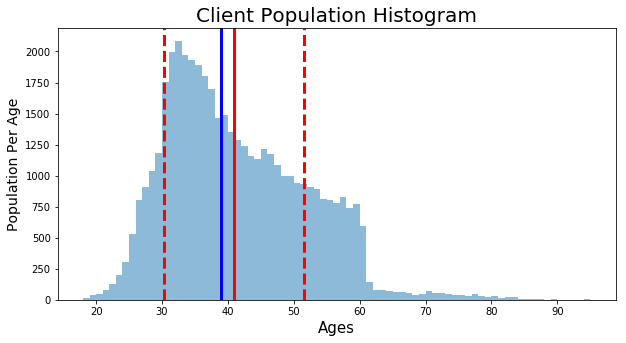

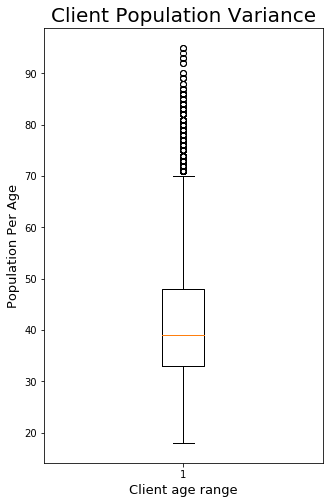

In [5]:
plt.figure(figsize=(10, 5))
# histogram of ages
plt.hist(bank_marketing.age, alpha=.5, bins=77, label='Age Population')
plt.axvline(bank_marketing.age.mean(), color='r', linestyle='solid', linewidth=3)
plt.axvline(bank_marketing.age.median(), color='b', linestyle='solid', linewidth=3)
plt.axvline(bank_marketing.age.mean()+bank_marketing.age.std(), color='r', linestyle='dashed', linewidth=3)
plt.axvline(bank_marketing.age.mean()-bank_marketing.age.std(), color='r', linestyle='dashed', linewidth=3)
plt.ylabel('Population Per Age', fontsize=14)
plt.title('Client Population Histogram', fontsize=20)
plt.xlabel('Ages', fontsize=15)
plt.show()

plt.figure(figsize=(5, 8))

# Boxplot of ages to discover outliers
plt.boxplot(bank_marketing['age'])
plt.ylabel('Population Per Age', fontsize=13)
plt.title('Client Population Variance', fontsize=20)
plt.xlabel('Client age range', fontsize=13)
plt.show()

These basic visuals of the population distribution show that there are enough datapoints beyond ~2 SD's (late 60s and above) to positively skew it.

There is a commonly reported figure by Western governments that the amounts of people living in old age has risen since last century, and this subset of the Portuguese population is reflecting this trend, despite any possible deviations these clients' socioeconomic attributes may have from the distributions reported by authorities.

Eurostat, the EU's statistics department, reported in 2012 that Portugal's rate of 129.4 elderly per 100 is nearly double that of 1990's. This is a shared central tendancy amongst the 28 nations, and Portugal in 6th place is above average.

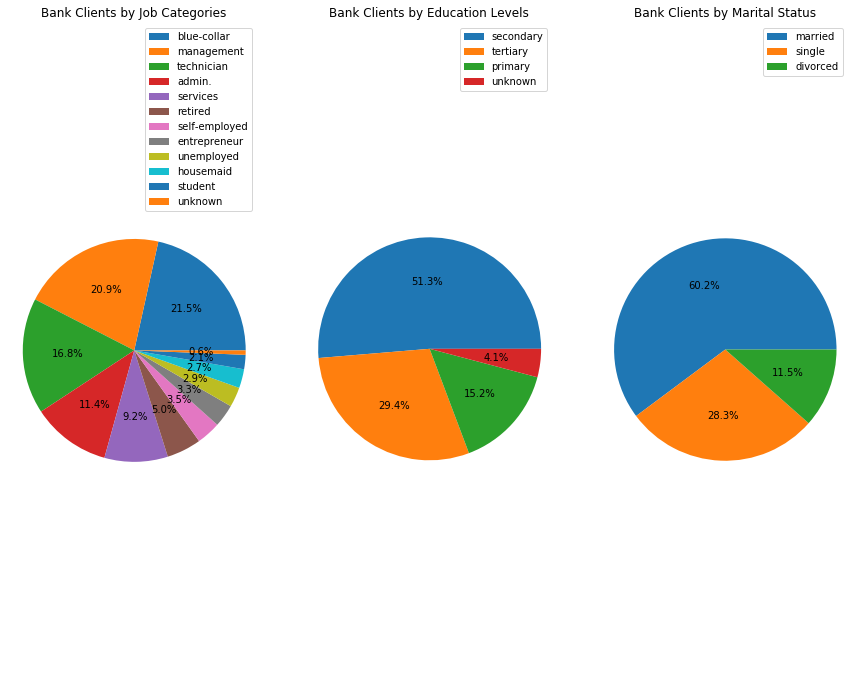

In [6]:
plt.figure(figsize=(15, 12))

# pie chart of jobs
plt.subplot(1, 3, 1)
occu_counts = pd.DataFrame(bank_marketing.job.value_counts())
plt.pie(occu_counts, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Bank Clients by Job Categories')
plt.legend(occu_counts.index, loc='best')

# pie chart of education
plt.subplot(1, 3, 2)
edu_counts = pd.DataFrame(bank_marketing.education.value_counts())
plt.pie(edu_counts, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Bank Clients by Education Levels')
plt.legend(edu_counts.index)

# pie chart of marital status
plt.subplot(1, 3, 3)
marital_counts = pd.DataFrame(bank_marketing.marital.value_counts())
plt.pie(marital_counts, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Bank Clients by Marital Status')
plt.legend(marital_counts.index)
plt.show()

The pie charts show that roughly half of the clients were educated up to secondary school, work blue-collar or in management, or are married. 

I shall note that secondary school is more deliberately specialized in Portugal. The diplomas children are able to achieve by 18 are also geared toward vocational or artistic careers. It is not surprising, then, to see that blue-collar, management, and technicians represent nearly 2/3rds of this dataset apart from the service industry. I suspect the service industry would be more represented if we were working with a US bank.

Eurostat also measures divorces and reported in 2011 that Portugal's divorces per 100 marriages skyrocketed from about 7 to 74, yet they were easily in the bottom 5 as measured in 1981. There are no explanations provided in the report I found, and I surely have suspicion of confounding variables. On the brighter side, Banco Portugal's clients may vary greatly from this statistic.

## 2) Which clients did and didn't subscribe to the long-term deposit product? How do they vary by financial attributes?

In [7]:
print('The amount of people surveyed who subsribed to the long-term'
      'bank deposit product is {}% as of Nov 2010'.format(np.multiply(100,1 - np.divide(
      bank_marketing.y.describe().freq,len(bank_marketing.y)))))

The amount of people surveyed who subsribed to the long-termbank deposit product is 11.698480458295546% as of Nov 2010


So, a little over a 10th of the targeted bank clients subscribed to the product. As stated in the dataset and attributes section, this is not the complete dataset used in the paper, which was over 70,000 clients. The paper states 9%.

However, this dataset does not represent a snapshot in time. About two and a half years passed since the initial clients were surveyed. These data did not capture any cancellations or changes in financial and socioeconomic attributes. This raises the importance of understanding the history of the dataset before using it for my purposes. These data were collected with the intent to improve efficacy of direct marketing efforts. The attributes of each client were not primarily collected to measure demographics.

Now, on to my purpose of measuring the demographics.

ages subscribed 
 count    5289.000000
mean       41.670070
std        13.497781
min        18.000000
25%        31.000000
50%        38.000000
75%        50.000000
max        95.000000
Name: age, dtype: float64 

ages not subscribed 
 count    39922.000000
mean        40.838986
std         10.172662
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64
balances subscribed 
 count     5289.000000
mean      1804.267915
std       3501.104777
min      -3058.000000
25%        210.000000
50%        733.000000
75%       2159.000000
max      81204.000000
Name: balance, dtype: float64 

balances not subscribed 
 count     39922.000000
mean       1303.714969
std        2974.195473
min       -8019.000000
25%          58.000000
50%         417.000000
75%        1345.000000
max      102127.000000
Name: balance, dtype: float64


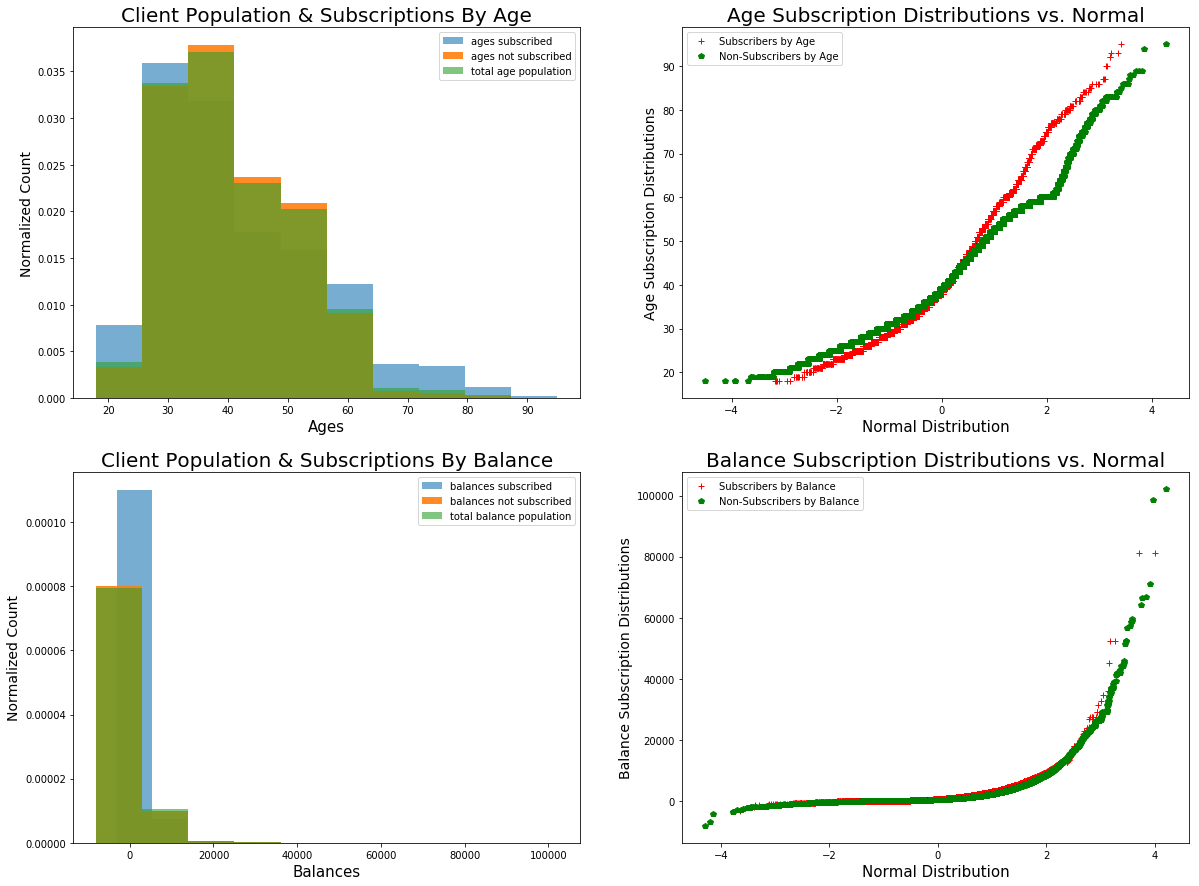

In [8]:
# Descriptions of ages subscribed/not subscribed
print('ages subscribed \n', bank_marketing.groupby(['y']).get_group('yes')['age'].describe(), '\n')
print('ages not subscribed \n', bank_marketing.groupby(['y']).get_group('no')['age'].describe())

plt.figure(figsize=(20, 15))

# Histogram of amount subscribed/not subscribed grouped by age and the age population
plt.subplot(2, 2, 1)
plt.hist(bank_marketing.groupby(['y']).get_group('yes')['age'], alpha=.6, label='ages subscribed', normed=True)
plt.hist(bank_marketing.groupby(['y']).get_group('no')['age'], alpha=.9, label='ages not subscribed', normed=True)
plt.hist(bank_marketing.age, alpha=.6, label='total age population', normed=True)
plt.legend(loc='best')
plt.ylabel('Normalized Count', fontsize=14)
plt.title('Client Population & Subscriptions By Age', fontsize=20)
plt.xlabel('Ages', fontsize=15)

# QQ plot of subscribers/non-subscribers grouped by age against normal distribution

## Generating arrays of subscribers/non-subscribers grouped by account age and normal distributions of same shapes
age_yes = bank_marketing.groupby(['y']).get_group('yes').loc[:,'age'].values
age_no = bank_marketing.groupby(['y']).get_group('no').loc[:,'age'].values
norm_age_yes = np.random.normal(0, 1, len(age_yes))
norm_age_no = np.random.normal(0, 1, len(age_no))

## Sorting arrays to create coherent plots!
age_yes.sort()
age_no.sort()
norm_age_yes.sort()
norm_age_no.sort()

## Generate normal vs age QQ plot
plt.subplot(2, 2, 2)
plt.plot(norm_age_yes, age_yes, '+', color='r')
plt.plot(norm_age_no, age_no, 'p', color='g')
plt.ylabel('Age Subscription Distributions', fontsize=14)
plt.title('Age Subscription Distributions vs. Normal', fontsize=20)
plt.xlabel('Normal Distribution', fontsize=15)
plt.legend(['Subscribers by Age', 'Non-Subscribers by Age'], loc='best')


# Descriptions of balances subscribed/not subscribed
print('balances subscribed \n', bank_marketing.groupby(['y']).get_group('yes')['balance'].describe(), '\n')
print('balances not subscribed \n', bank_marketing.groupby(['y']).get_group('no')['balance'].describe())

# Histogram of amount subscribed/not subscribed grouped by balance and the balance population
plt.subplot(2, 2, 3)
plt.hist(bank_marketing.groupby(['y']).get_group('yes')['balance'], alpha=.6, label='balances subscribed', normed=True)
plt.hist(bank_marketing.groupby(['y']).get_group('no')['balance'], alpha=.9, label='balances not subscribed', normed=True)
plt.hist(bank_marketing.balance, alpha=.6, label='total balance population', normed=True)
plt.legend(loc='best')
plt.ylabel('Normalized Count', fontsize=14)
plt.title('Client Population & Subscriptions By Balance', fontsize=20)
plt.xlabel('Balances', fontsize=15)

# QQ plot of subscribers/non-subscribers grouped by age against normal distribution

## Generating arrays of subscribers/non-subscribers grouped by account balance and normal distributions of same shapes
balance_yes = bank_marketing.groupby(['y']).get_group('yes').loc[:,'balance'].values
balance_no = bank_marketing.groupby(['y']).get_group('no').loc[:,'balance'].values
norm_balance_yes = np.random.normal(0, 1, len(balance_yes))
norm_balance_no = np.random.normal(0, 1, len(balance_no))

## Sorting arrays to create coherent plots!
balance_yes.sort()
balance_no.sort()
norm_balance_yes.sort()
norm_balance_no.sort()

## Generate normal vs balance QQ plot
plt.subplot(2, 2, 4)
plt.plot(norm_balance_yes, balance_yes, '+', color='r')
plt.plot(norm_balance_no, balance_no, 'p', color='g')
plt.ylabel('Balance Subscription Distributions', fontsize=14)
plt.title('Balance Subscription Distributions vs. Normal', fontsize=20)
plt.xlabel('Normal Distribution', fontsize=15)
plt.legend(['Subscribers by Balance', 'Non-Subscribers by Balance'],loc='best')
plt.show()

All of the distributions are positively skewed and the subscribed/not-subscribed groups by age and balance are similarly distributed to their respective populations. To emphasize my interpretation of distribution similarities, I plotted 3 histograms on one figure for age and balance.

The interquartile ranges are similar for the histograms grouped by age though the amount of clients not subscribed is almost one order of magnitude larger.

The mean balance of the subscribed group is unsurprisingly above the mean of those not subscribed, though there is a larger standard deviation for the subscribed group. I expected signs of prudence for the subscribed group given that the product is a long-term investment vehicle. However, both have interquartile ranges that I suspect aren't significantly different for the bank to make meaningful decisions/projections. For example, certificate of deposits may start at 1k or 2k euros like in the US at $1k or $2k, respectively. Yet the top of both groups' IQ ranges are still balances that can only be used for the entry level to most savings products. 

So neither of the groups are normally distributed. The QQ plot for balances reflects how the histograms contained many more datapoints in the lower account balances than the younger ages. Both balance distributions on the QQ plot are flat from -4 STD's to ~1 STD, wheras the flatness for ages is only between -3 and -4.

Of note is that beyond 3 STD's on the ages QQ plot, there is almost a straight line, indicating a fit to the normal distribution. Unfortunately it appears in statistical analysis, we avoid drawing conclusions based on outliers. I'd like to believe this hints at something about past consumer behavior before the modern economy became wacky with its gigantic sovereign and consumer debt as well as gigantic amounts of money printed by central banks used to buy sovereign bonds. The question is: were consumer bank balances from the guilded age to 1970 a better fit to the normal distribution than now?

These plots also suggest that the amount of subscribers and non-subscribers for each group did not disturb the variance observed in the population. Below we will observe the percent of subscribers grouped by age and balance to see if it fits to the population and/or normal distribution.

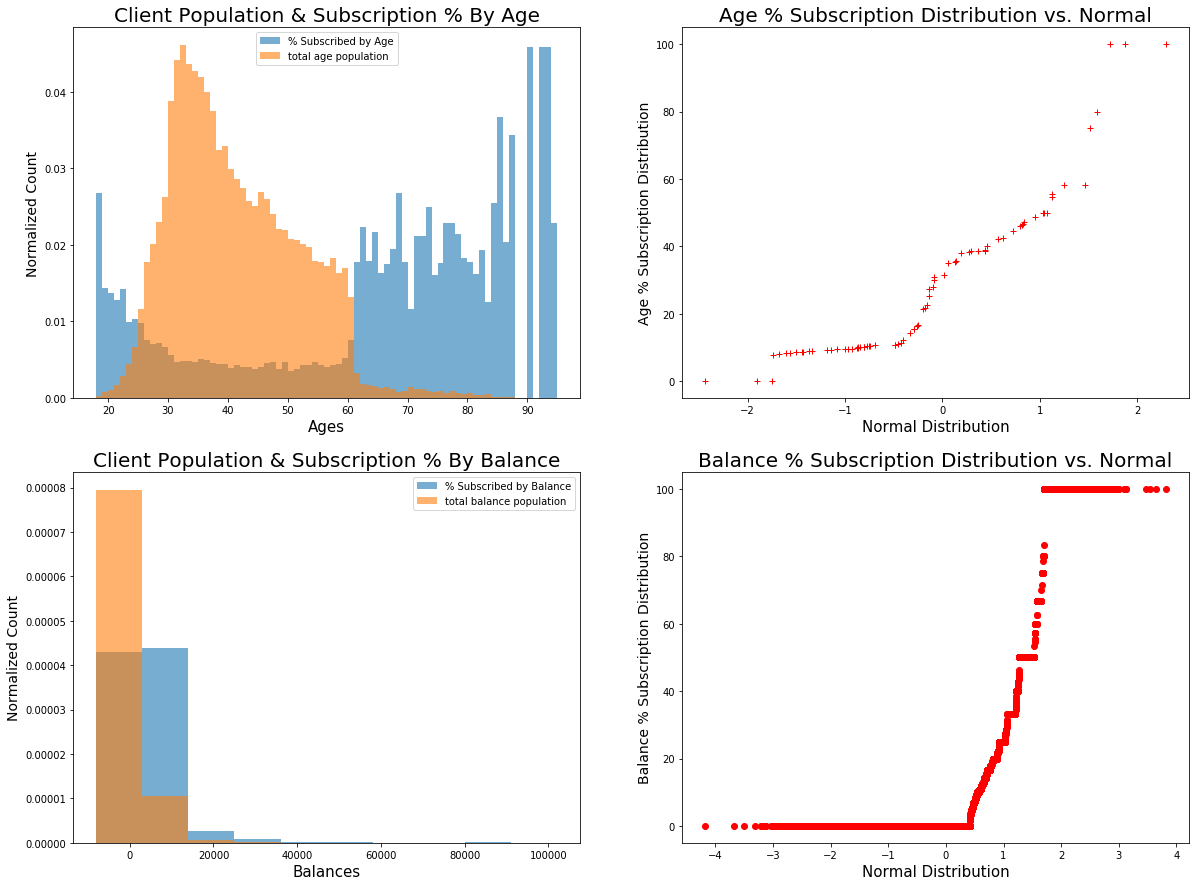

In [9]:
plt.figure(figsize=(20,15))

# Generate proportion of yes grouped by age
yes_age = bank_marketing.groupby('age')['y'].describe().groupby('top').get_group('yes')['freq']/bank_marketing.groupby('age')['y'].describe().groupby('top').get_group('yes')['count']
no_age = 1-bank_marketing.groupby('age')['y'].describe().groupby('top').get_group('no')['freq']/bank_marketing.groupby('age')['y'].describe().groupby('top').get_group('no')['count']
prop_age = 100*yes_age.append(no_age,verify_integrity=True).sort_index()
prop_age_index = pd.Series(prop_age.index)

# Plot histogram of percent subscribed grouped by age
plt.subplot(2, 2, 1)
plt.hist(prop_age.index.tolist(), weights=prop_age.tolist(), bins=77, normed=True, alpha=.6, label='% Subscribed by Age')
plt.hist(bank_marketing.age, alpha=.6, label='total age population', normed=True, bins=77)
plt.legend(loc='best')
plt.ylabel('Normalized Count', fontsize=14)
plt.title('Client Population & Subscription % By Age', fontsize=20)
plt.xlabel('Ages', fontsize=15)

# QQ plot of percent subscribers grouped by age against normal distribution

## Generating array of normal distribution of same shape
norm_prop_age = np.random.normal(0, 1, len(prop_age))

## Sorting arrays to create coherent plots!
norm_prop_age.sort()
prop_age.values.sort()
## Generate normal vs age QQ plot
plt.subplot(2, 2, 2)
plt.plot(norm_prop_age, prop_age, '+', color='r')
plt.ylabel('Age % Subscription Distribution', fontsize=14)
plt.title('Age % Subscription Distribution vs. Normal', fontsize=20)
plt.xlabel('Normal Distribution', fontsize=15)
plt.legend(loc='best')


# Generate proportion of yes grouped by balance
yes_balance = bank_marketing.groupby('balance')['y'].describe().groupby('top').get_group('yes')['freq']/bank_marketing.groupby('balance')['y'].describe().groupby('top').get_group('yes')['count']
no_balance = 1-bank_marketing.groupby('balance')['y'].describe().groupby('top').get_group('no')['freq']/bank_marketing.groupby('balance')['y'].describe().groupby('top').get_group('no')['count']
prop_balance = 100*yes_balance.append(no_balance,verify_integrity=True).sort_index()
prop_balance_index = pd.Series(prop_balance.index)

# Plot histogram of percent subscribed grouped by balance
plt.subplot(2, 2, 3)
plt.hist(prop_balance.index.tolist(), weights=prop_balance.tolist(), normed=True, alpha=.6, label='% Subscribed by Balance')
plt.hist(bank_marketing.balance, alpha=.6, label='total balance population', normed=True)
plt.legend(loc='best')
plt.ylabel('Normalized Count', fontsize=14)
plt.title('Client Population & Subscription % By Balance', fontsize=20)
plt.xlabel('Balances', fontsize=15)

# QQ plot of percent subscribers grouped by balance against normal distribution

## Generating array of normal distribution of same shape
norm_prop_balance = np.random.normal(0, 1, len(prop_balance))

## Sorting arrays to create coherent plots!
norm_prop_balance.sort()
prop_balance.values.sort()
## Generate normal vs balance QQ plot
plt.subplot(2, 2, 4)
plt.plot(norm_prop_balance, prop_balance, 'o', color='r')
plt.ylabel('Balance % Subscription Distribution', fontsize=14)
plt.title('Balance % Subscription Distribution vs. Normal', fontsize=20)
plt.xlabel('Normal Distribution', fontsize=15)
plt.legend(loc='best')
plt.show()

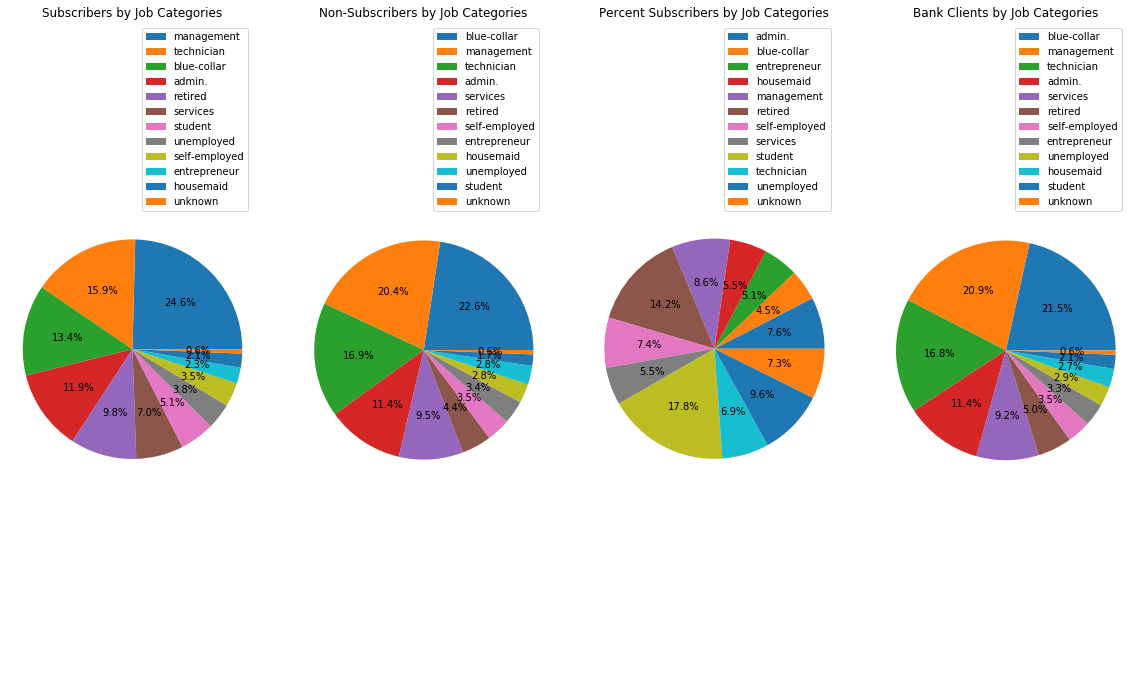

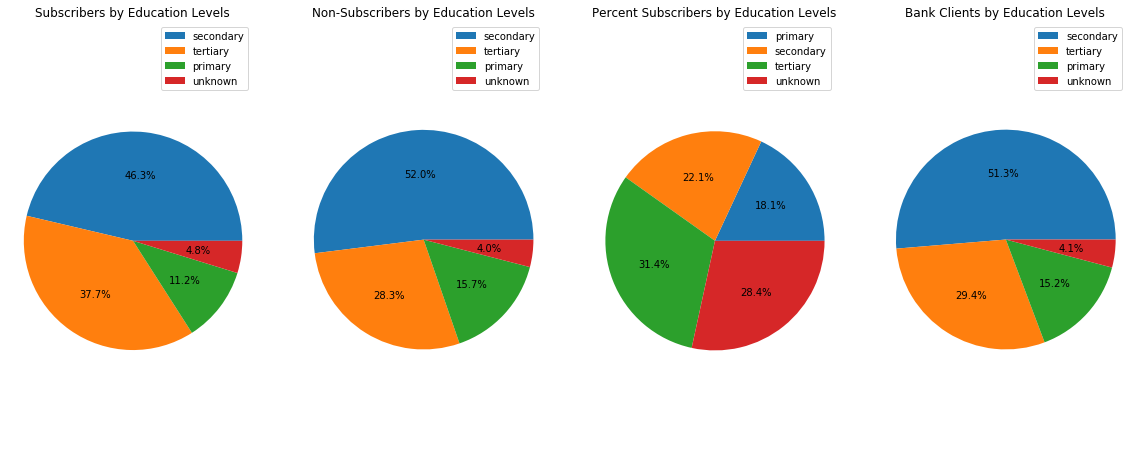

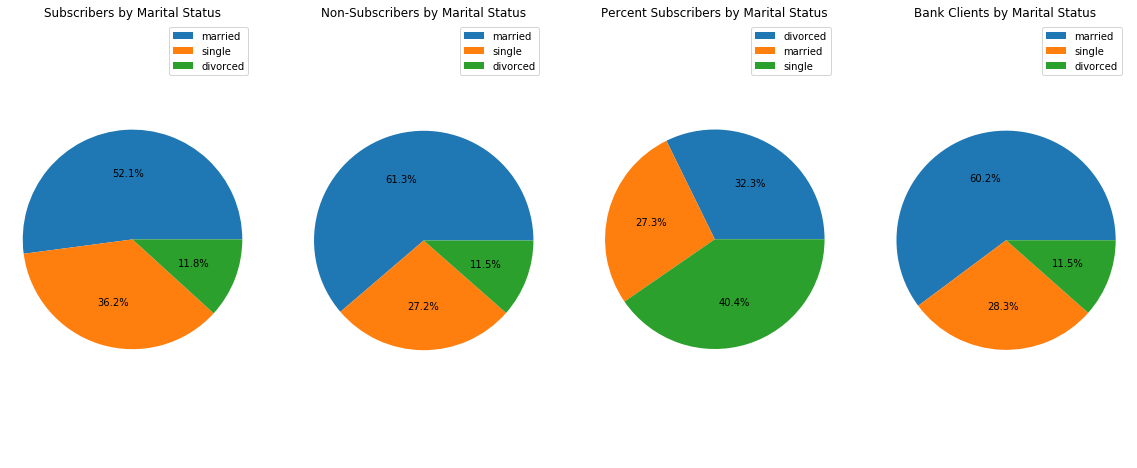

In [10]:
plt.figure(figsize=(20, 12))

# pie chart of product subscribers grouped by job category
plt.subplot(1, 4, 1)
plt.pie(bank_marketing.groupby('y').get_group('yes').job.value_counts(), autopct='%1.1f%%')
plt.axis('equal')
plt.title('Subscribers by Job Categories')
plt.legend(bank_marketing.groupby('y').get_group('yes').job.value_counts().index)

# pie chart of non-subscribers by job category
plt.subplot(1, 4, 2)
plt.pie(bank_marketing.groupby('y').get_group('no').job.value_counts(), autopct='%1.1f%%')
plt.axis('equal')
plt.title('Non-Subscribers by Job Categories')
plt.legend(bank_marketing.groupby('y').get_group('no').job.value_counts().index)

# pie chart of percent subscribers grouped by job category

## Generate proportion of yes grouped by job
no_job = 1-bank_marketing.groupby('job')['y'].describe().groupby('top').get_group('no')['freq']/bank_marketing.groupby('job')['y'].describe().groupby('top').get_group('no')['count']
prop_job = 100*no_job.sort_index()
prop_job_index = pd.Series(prop_job.index)

plt.subplot(1, 4, 3)
plt.pie(prop_job, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Percent Subscribers by Job Categories')
plt.legend(prop_job.index, loc='upper right')

# pie chart of jobs
job_counts = pd.DataFrame(bank_marketing.job.value_counts())
plt.subplot(1, 4, 4)
plt.pie(job_counts, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Bank Clients by Job Categories')
plt.legend(job_counts.index)
plt.show()

plt.figure(figsize=(20, 8))

# pie chart of product subscribers grouped by education level
plt.subplot(1, 4, 1)
plt.pie(bank_marketing.groupby('y').get_group('yes').education.value_counts(), autopct='%1.1f%%')
plt.axis('equal')
plt.title('Subscribers by Education Levels')
plt.legend(bank_marketing.groupby('y').get_group('yes').education.value_counts().index)

# pie chart of non-subscribers by education level
plt.subplot(1, 4, 2)
plt.pie(bank_marketing.groupby('y').get_group('no').education.value_counts(), autopct='%1.1f%%')
plt.axis('equal')
plt.title('Non-Subscribers by Education Levels')
plt.legend(bank_marketing.groupby('y').get_group('no').education.value_counts().index)

# pie chart of percent subscribers grouped by education level

## Generate proportion of yes grouped by education
no_education = 1-bank_marketing.groupby('education')['y'].describe().groupby('top').get_group('no')['freq']/bank_marketing.groupby('education')['y'].describe().groupby('top').get_group('no')['count']
prop_education = 100*no_education.sort_index()
prop_education_index = pd.Series(prop_education.index)

plt.subplot(1, 4, 3)
plt.pie(prop_education, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Percent Subscribers by Education Levels')
plt.legend(prop_education.index)

# pie chart of education levels
edu_counts = pd.DataFrame(bank_marketing.education.value_counts())
plt.subplot(1, 4, 4)
plt.pie(edu_counts, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Bank Clients by Education Levels')
plt.legend(edu_counts.index)
plt.show()

plt.figure(figsize=(20, 8))

# pie chart of product subscribers grouped by Marital Status
plt.subplot(1, 4, 1)
plt.pie(bank_marketing.groupby('y').get_group('yes').marital.value_counts(), autopct='%1.1f%%')
plt.axis('equal')
plt.title('Subscribers by Marital Status')
plt.legend(bank_marketing.groupby('y').get_group('yes').marital.value_counts().index)

# pie chart of non-subscribers by Marital Status
plt.subplot(1, 4, 2)
plt.pie(bank_marketing.groupby('y').get_group('no').marital.value_counts(), autopct='%1.1f%%')
plt.axis('equal')
plt.title('Non-Subscribers by Marital Status')
plt.legend(bank_marketing.groupby('y').get_group('no').marital.value_counts().index)

# pie chart of percent subscribers grouped by Marital Status

## Generate proportion of yes grouped by Marital Status
no_marital = 1-bank_marketing.groupby('marital')['y'].describe().groupby('top').get_group('no')['freq']/bank_marketing.groupby('marital')['y'].describe().groupby('top').get_group('no')['count']
prop_marital = 100*no_marital.sort_index()
prop_marital_index = pd.Series(prop_marital.index)

plt.subplot(1, 4, 3)
plt.pie(prop_marital, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Percent Subscribers by Marital Status')
plt.legend(prop_marital.index)

# pie chart of Martial Status
mar_counts = pd.DataFrame(bank_marketing.marital.value_counts())
plt.subplot(1, 4, 4)
plt.pie(mar_counts, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Bank Clients by Marital Status')
plt.legend(mar_counts.index)
plt.show()

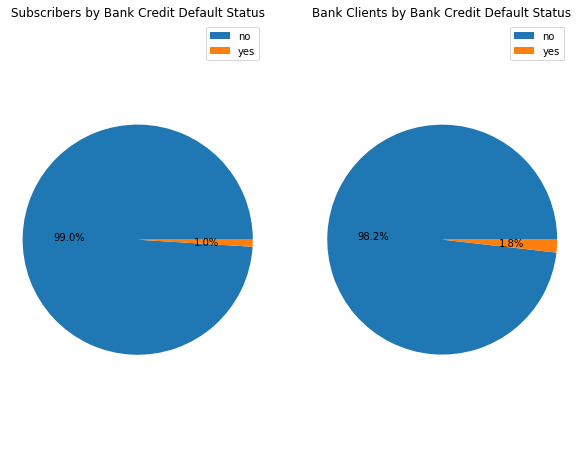

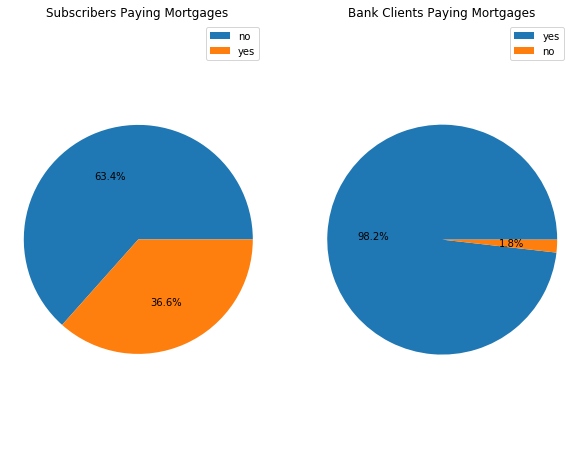

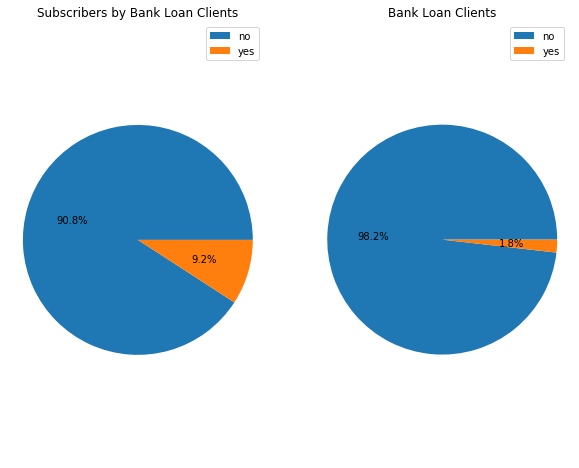

In [11]:
plt.figure(figsize=(10, 8))

# pie chart of product subscribers by bank credit status.
buyer_def_counts = pd.DataFrame(bank_marketing.loc[lambda df: df.y==
                    'yes','default'].value_counts())
plt.subplot(1, 2, 1)
plt.pie(buyer_def_counts, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Subscribers by Bank Credit Default Status')
plt.legend(buyer_def_counts.index)

#pie chart of bank credit status
def_counts = pd.DataFrame(bank_marketing.default.value_counts())
plt.subplot(1, 2, 2)
plt.pie(def_counts, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Bank Clients by Bank Credit Default Status')
plt.legend(def_counts.index)
plt.show()

plt.figure(figsize=(10, 8))

# pie chart of product subscribers by housing status
buyer_house_counts = pd.DataFrame(bank_marketing.loc[lambda df: df.y==
                    'yes','housing'].value_counts())
plt.subplot(1, 2, 1)
plt.pie(buyer_house_counts, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Subscribers Paying Mortgages')
plt.legend(buyer_house_counts.index)

#pie chart of housing status
house_counts = pd.DataFrame(bank_marketing.housing.value_counts())
plt.subplot(1, 2, 2)
plt.pie(def_counts, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Bank Clients Paying Mortgages')
plt.legend(house_counts.index)
plt.show()

plt.figure(figsize=(10, 8))

# pie chart of product subscribers by bank loan clients
buyer_loan_counts = pd.DataFrame(bank_marketing.loc[lambda df:
                    df.y=='yes','loan'].value_counts())
plt.subplot(1, 2, 1)
plt.pie(buyer_loan_counts, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Subscribers by Bank Loan Clients')
plt.legend(buyer_loan_counts.index)

#pie chart of loan status
loan_counts = pd.DataFrame(bank_marketing.loan.value_counts())
plt.subplot(1, 2, 2)
plt.pie(def_counts, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Bank Loan Clients')
plt.legend(loan_counts.index)
plt.show()

The main takeaway from the bar graphs of financial attributes for subscribers is that just like the numeric attributes of age and balance, there is not enough variability to help the bank predict who really is more likely to subscribe. However, there is some predictive capability for clients who currently have loans, whether or not they carry a default status. Or perhaps more advanced predictive analysis is needed to break through how similar, in simple descriptive statistics, these groups appear to the population.

When it comes to analyzing the percent and averages, there is something to work with, but the predictive value of taking these statistics should be studied since the distributions don't follow the normal.

## 3) How did client engagement vary during the campaign?

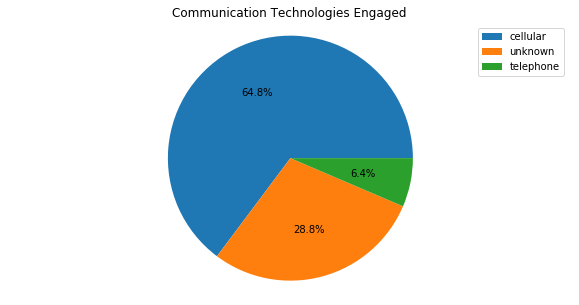

In [12]:
# Pie plot of communication technologies used by clients to answer campaign calls
plt.figure(figsize=(10, 5))
plt.pie(bank_marketing.contact.value_counts(), autopct='%1.1f%%')
plt.axis('equal')
plt.title('Communication Technologies Engaged')
plt.legend(bank_marketing.contact.value_counts().index)
plt.show()

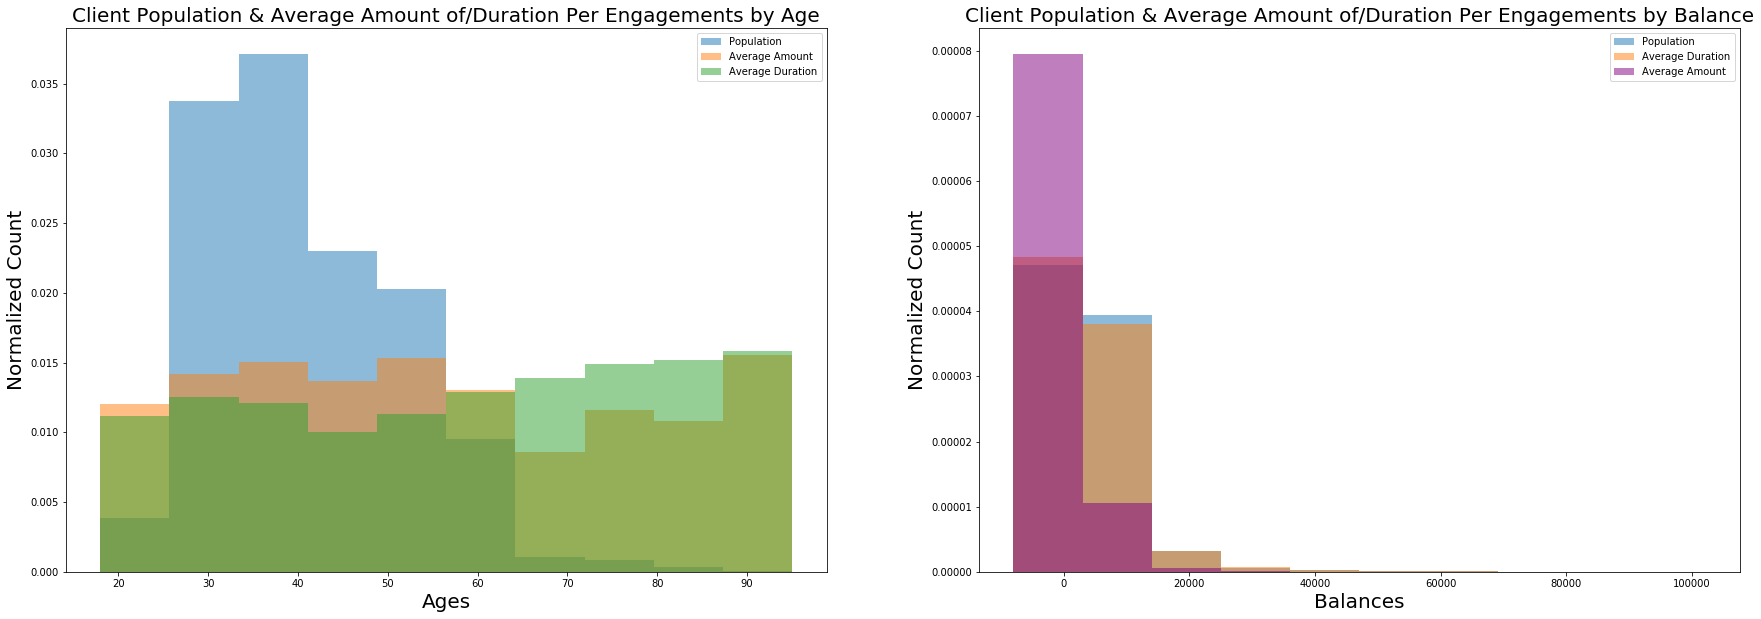

In [14]:
plt.figure(figsize=(30, 10))

# Histogram of Client Population & Average Amount of/Duration Per Engagements by Age
plt.subplot(1, 2, 1)
plt.hist(bank_marketing.age, normed=True, alpha = 0.5)
plt.hist(bank_marketing.groupby('age').sum().index,weights=bank_marketing.groupby('age').mean().campaign.values, normed=True, alpha=0.5)
plt.hist(bank_marketing.groupby('age').sum().index,weights=bank_marketing.groupby('age').mean().duration.values, normed=True, alpha=0.5)
plt.legend(['Population', 'Average Amount', 'Average Duration'], loc='best')
plt.ylabel('Normalized Count', fontsize=20)
plt.title('Client Population & Average Amount of/Duration Per Engagements by Age', fontsize=20)
plt.xlabel('Ages', fontsize=20)

# Histogram of Client Population & Average Amount of/Duration Per Engagements by Balance
plt.subplot(1, 2, 2)
plt.hist(bank_marketing.groupby('balance').sum().index,weights=bank_marketing.groupby('balance').mean().duration.values, normed=True, alpha=0.5)
plt.hist(bank_marketing.groupby('balance').sum().index,weights=bank_marketing.groupby('balance').mean().campaign.values, normed=True, alpha=0.5)
plt.hist(bank_marketing.balance, normed=True, alpha = 0.5, color='purple')
plt.legend(['Population', 'Average Duration', 'Average Amount'], loc='best')
plt.ylabel('Normalized Count', fontsize=20)
plt.title('Client Population & Average Amount of/Duration Per Engagements by Balance', fontsize=20)
plt.xlabel('Balances', fontsize=20)
plt.show()

The histograms of the average amount and duration of engagment show a deviation from the age and balance population distributions as expected.

Here again I plotted 3 normalized histograms to emphasize my interpretation. For the average amount and duration of engagements grouped by age, we can see that the marketing team managed to conduct a relatively consistent campaign. On average, every age group experienced similar amounts of time per engagement and amount of engagements. I shall note that the total amount of and time per engagement still closely fit to the age population distribution.

3 normalized histograms are plotted as well for average duration and amount grouped by balance. Just as it is for age, the average amount and duration of engagements grouped by balance have extermely similar distributions, so there was consistency here. Compared to the balance population, these distributions show that, on average, the campaign contacted lower-balance clients much less than they are represented in the population. However, the average lower-balance client was still engaged more than the others. The total amount of and time per engagement grouped by balance also closely fit to the age population distribution.

# Further Research

During the 1st analytic question, I discussed the adherence of this data set to the oft reported trend that the elderly population is living longer a whole lot more than before, in aggregate.

This causes me to raise a question about the variance by age in deposits and employment status of these clients given my alegiance to the economic school of thought called Austrian Economics. Its origins are associated with the prominent figure and mentor Ludwig von Mises during the time it was gaining global traction in the late 1800s. These economics say that young people are coerced to generate money for the old, one of the most important reasons being ever increasing sovereign debt that pays for more services (e.g. retirement funds) than tax can afford. The theory is that these conditions actually prevent young people from generating enough money to take care of the old. Therefore, the next step would be to observe central banking's economic indicators keeping in mind to explore variance in deposits and employment by age. I'd expect to see more employment and savings from old people, and relatively less employed younger people.

This data was originally used with the goal to improve a specific marketing strategy, yet it can be used in economic analysis. The issues and economic indicators of savings rates and inflation dovetail into this study so gently - savings rates may already sit in the banks' databases and inflation effects were already integrated into the revision of this dataset. I didn't choose to work with the revised dataset because of the admission of missing values amongst the socioeconomic data added by the researchers. 

A question to get started on such work is - are the relevant client central tendencies and variances consistent over time during these marketing campgaigns? Small errors between the distributions should become a powerful foundation for integrating and reflecting developments over time in the reporting. Especially keep an eye out for redefinitions of macroeconomic key performance indicators!

# Citations

[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014 [UCI ML Repo](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#)

PORDATA, 2014 Edition. Portrait of Portugal in Europe. [Source](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=20&cad=rja&uact=8&ved=0ahUKEwjKlerM1N3XAhUC5GMKHfdnC28QFghaMBM&url=http%3A%2F%2Fwww.pordata.pt%2Febooks%2FEN%2FPT_EU2014v201506121000%2Ffiles%2Fextfiles%2FdownloadURL.pdf&usg=AOvVaw0AZsInDcjkKVf2jY0g3dDw)